In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor

In [5]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>

## MERGE ALL DATASETS

In [ ]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [ ]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [ ]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [ ]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


## MERGE TRANSACTIONS AND MARKETING

In [ ]:
# Merge the dataframes
transaction_marketing = pd.merge(transactions, marketing, on='customer_id', how='outer')
transaction_marketing.head(100)

,transaction_id,customer_id,transaction_date,transaction_amount,product_category,campaign_id,response,promotion_type,campaign_date
0,1,1,2024-02-03,165.56,Clothing,1,No,Buy One Get One,2024-02-29
1,1,1,2024-02-03,165.56,Clothing,2,No,Discount,2024-01-24
2,1,1,2024-02-03,165.56,Clothing,3,No,Free Shipping,2024-03-05
3,1,1,2024-02-03,165.56,Clothing,4,Yes,Buy One Get One,2024-01-10
4,2,1,2024-03-02,699.01,Home Goods,1,No,Buy One Get One,2024-02-29
...,...,...,...,...,...,...,...,...,...
95,27,4,2022-08-24,791.53,Electronics,14,No,Buy One Get One,2022-05-15
96,28,4,2022-02-27,36.56,Clothing,11,No,Free Shipping,2022-06-04
97,28,4,2022-02-27,36.56,Clothing,12,No,Discount,2022-03-02
98,28,4,2022-02-27,36.56,Clothing,13,Yes,Free Shipping,2022-07-22


## LTV Calculation

In [ ]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [ ]:
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13


## FEATURE ENGINEERING & DATA CLEANING

In [ ]:
# Tier LTV 
joint_data['LTV_Tier'] = pd.qcut(joint_data['LTV'], 3, labels=['low', 'medium', 'high'])

In [ ]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [ ]:
# customer age (How long they have been a member)
joint_data['Customer_Age'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Age']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Age, Length: 10000, dtype: timedelta64[ns]

In [ ]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount
customer_id,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,low,118 days,584.913333
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,medium,777 days,675.702222
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,low,544 days,242.478333
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,medium,243 days,393.734000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,high,494 days,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,medium,240 days,549.820000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,medium,200 days,487.358333
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,low,135 days,1167.710000


In [ ]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [ ]:
# convert to an integer number of days for most recent purchase
joint_data['most_recent_purchase_in_days'] = joint_data['most_recent_purchase_date'].dt.days

In [ ]:
# convert to an integer number of days for customer age
joint_data['Customer_Age_in_days']=joint_data['Customer_Age'].dt.days

In [ ]:
# Customer Tier (based on how much their site visits)
def Customer_Tier(x):
    if x<=10:
        return 'inactive online'
    if x>=11 and x<100:
        return 'regularly checks online'
    if x>=100:
        return 'actively engaged'
    else:
        return 'member'

In [ ]:
joint_data['Customer_Tier'] = joint_data['number_of_site_visits'].apply(Customer_Tier)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier
customer_id,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,low,118 days,584.913333,75 days,75,118,inactive online
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,medium,777 days,675.702222,219 days,219,777,actively engaged
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,low,544 days,242.478333,551 days,551,544,actively engaged
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,medium,243 days,393.734000,638 days,638,243,actively engaged
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,high,494 days,646.856250,364 days,364,494,actively engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,medium,240 days,549.820000,292 days,292,240,actively engaged
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,medium,200 days,487.358333,492 days,492,200,inactive online
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,low,135 days,1167.710000,122 days,122,135,regularly checks online


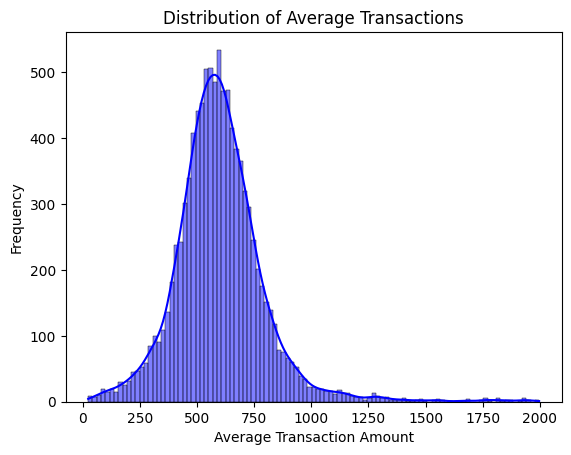

In [ ]:
# Histogram to determine data distribution
sns.histplot(joint_data['Avg_Transaction_Amount'], kde=True, color='blue')  # KDE adds a density curve
plt.title('Distribution of Average Transactions')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
def Spending_Tendency(x):
    if x <= 488.34:
        return 'low'
    elif 488.35 <= x <= 692.70:
        return 'medium'
    elif x >= 692.71:
        return 'high'               

In [ ]:
joint_data['Spending_Tendency'] = joint_data['Avg_Transaction_Amount'].apply(Spending_Tendency)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier,Spending_Tendency,Recently_Purchased,Avg_Transaction_Time,binary_output
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,4747,10,15,1,6,3509.48,...,118 days,584.913333,75 days,75,118,1,medium,2,19.666667,0
2,2021-09-08,2023-10-25,NaN,Male,2074,285,49,51,9,6081.32,...,777 days,675.702222,219 days,219,777,0,medium,2,86.333333,0
3,2021-06-01,2022-11-27,NaN,NaN,4613,192,73,25,6,1454.87,...,544 days,242.478333,551 days,551,544,0,low,2,90.666667,0
4,2022-01-01,2022-09-01,29.0,Male,1916,110,30,17,20,7874.68,...,243 days,393.734000,638 days,638,243,0,low,2,12.150000,0
5,2022-01-24,2023-06-02,NaN,Male,1433,161,2,7,24,15524.55,...,494 days,646.856250,364 days,364,494,0,medium,2,20.583333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,2384,119,47,16,10,5498.20,...,240 days,549.820000,292 days,292,240,0,medium,2,24.000000,0
9997,2022-07-09,2023-01-25,26.0,Male,2315,3,33,14,12,5848.30,...,200 days,487.358333,492 days,492,200,1,low,2,16.666667,0
9998,2023-09-17,2024-01-30,39.0,Male,4017,53,17,5,3,3503.13,...,135 days,1167.710000,122 days,122,135,2,high,2,45.000000,0


In [ ]:
# Recently purchased (tiering based on how recent their last purchase was)
def Recently_Purchased(x):
    if x<=14:
        return '2 weeks or less'
    if x>=15 and x<59:
        return '1-2 months ago'
    if x>=60:
        return '2+ months ago'
    else:
        return 'not applicable'

In [ ]:
joint_data['Recently_Purchased'] = joint_data['most_recent_purchase_in_days'].apply(Recently_Purchased)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV,LTV_Tier,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier,Spending_Tendency,Recently_Purchased
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,3509.48,low,118 days,584.913333,75 days,75,118,inactive online,Medium,2+ months ago
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,6081.32,medium,777 days,675.702222,219 days,219,777,actively engaged,High,2+ months ago
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,1454.87,low,544 days,242.478333,551 days,551,544,actively engaged,Low,2+ months ago
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,7874.68,medium,243 days,393.734000,638 days,638,243,actively engaged,Low,2+ months ago
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,15524.55,high,494 days,646.856250,364 days,364,494,actively engaged,High,2+ months ago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,5498.20,medium,240 days,549.820000,292 days,292,240,actively engaged,Medium,2+ months ago
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,5848.30,medium,200 days,487.358333,492 days,492,200,inactive online,Low,2+ months ago
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,3503.13,low,135 days,1167.710000,122 days,122,135,regularly checks online,Very High,2+ months ago


In [ ]:
# Avg Transaction Time = how often do they make a transaction (in days)
joint_data['Avg_Transaction_Time'] = joint_data['Customer_Age_in_days']/joint_data['transaction_id']
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV_Tier,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier,Spending_Tendency,Recently_Purchased,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,low,118 days,584.913333,75 days,75,118,inactive online,Medium,2+ months ago,19.666667
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,medium,777 days,675.702222,219 days,219,777,actively engaged,High,2+ months ago,86.333333
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,544 days,242.478333,551 days,551,544,actively engaged,Low,2+ months ago,90.666667
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,medium,243 days,393.734000,638 days,638,243,actively engaged,Low,2+ months ago,12.150000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,high,494 days,646.856250,364 days,364,494,actively engaged,High,2+ months ago,20.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,240 days,549.820000,292 days,292,240,actively engaged,Medium,2+ months ago,24.000000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,medium,200 days,487.358333,492 days,492,200,inactive online,Low,2+ months ago,16.666667
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,low,135 days,1167.710000,122 days,122,135,regularly checks online,Very High,2+ months ago,45.000000


## TRANSACTIONS AMOUNT LAST 30 DAYS AND LAST YEAR (ie. More Feature Engineering)

In [ ]:
transactions

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics
...,...,...,...,...,...
129540,129541,10000,2023-05-27,371.70,Home Goods
129541,129542,10000,2023-06-11,1245.23,Electronics
129542,129543,10000,2023-06-28,745.74,Electronics
129543,129544,10000,2023-07-21,587.37,Home Goods


In [ ]:
# Convert the 'date' column to datetime type
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [ ]:
# set reference date
last_date = transactions['transaction_date'].max()

In [ ]:
# Define the time periods
days_30 = last_date - timedelta(days=30)

In [ ]:
days_365 = last_date - timedelta(days=365)

In [ ]:
last_30_days_transactions = transactions[(transactions['transaction_date'] > days_30) & (transactions['transaction_date'] <= last_date)]

In [ ]:
last_365_days_transactions = transactions[(transactions['transaction_date'] > days_365) & (transactions['transaction_date'] <= last_date)]

In [ ]:
def calculate_rfm(data, end_date, days_label):
    rfm = data.groupby('customer_id').agg(
        recency = ('transaction_date', lambda x: (end_date - x.max()).days),
        frequency = ('transaction_id', 'count'),
        monetary = ('transaction_amount', 'sum')
    ).rename(columns={
        'recency': f'Recency_{days_label}',
        'frequency': f'Frequency_{days_label}',
        'monetary': f'Monetary_{days_label}'
    })
    return rfm

In [ ]:
rfm_30 = calculate_rfm(last_30_days_transactions, last_date, '30')
rfm_30

# Conclusion: not enough data to conduct any modeling for rfm on last 30 days

,Recency_30,Frequency_30,Monetary_30
customer_id,,,
7,13,3,1018.16
48,19,1,439.69
59,24,8,4848.62
66,8,20,10795.72
90,1,19,11212.55
...,...,...,...
9869,28,1,408.71
9873,1,20,8405.83
9875,28,1,114.28


In [ ]:
rfm_365 = calculate_rfm(last_365_days_transactions, last_date, '365')
rfm_365

,Recency_365,Frequency_365,Monetary_365
customer_id,,,
1,80,6,3509.48
7,13,5,1339.82
8,305,7,4693.03
9,306,1,252.74
12,150,5,3221.32
...,...,...,...
9991,30,25,19857.11
9992,119,18,12543.37
9996,355,3,1096.25


In [ ]:
# Score Frequency and Monetary: Higher values are better
rfm_365['F_Score'] = pd.qcut(rfm_365['Frequency_365'], 5, labels=[1, 2, 3, 4, 5])
rfm_365['M_Score'] = pd.qcut(rfm_365['Monetary_365'], 5, labels=[1, 2, 3, 4, 5])
rfm_365
# Recency was not used as a lower score would be better under this model and would require entirely changing the dataset

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score
customer_id,,,,,
1,80,6,3509.48,3,3
7,13,5,1339.82,2,2
8,305,7,4693.03,3,3
9,306,1,252.74,1,1
12,150,5,3221.32,2,3
...,...,...,...,...,...
9991,30,25,19857.11,5,5
9992,119,18,12543.37,5,5
9996,355,3,1096.25,2,1


In [ ]:
# RFM Score by summing individual scores
rfm_365['F_Score'] = rfm_365['F_Score'].astype(int)
rfm_365['M_Score'] = rfm_365['M_Score'].astype(int)

rfm_365['RFM_Score'] = rfm_365[['F_Score', 'M_Score']].sum(axis=1)
rfm_365

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score,RFM_Score
customer_id,,,,,,
1,80,6,3509.48,3,3,6
7,13,5,1339.82,2,2,4
8,305,7,4693.03,3,3,6
9,306,1,252.74,1,1,2
12,150,5,3221.32,2,3,5
...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,10
9992,119,18,12543.37,5,5,10
9996,355,3,1096.25,2,1,3


In [ ]:
# Create quantile-based bins
rfm_365['RFM_Segment'] = pd.qcut(rfm_365['RFM_Score'], q=3, labels=['Low Value', 'Medium Value', 'High Value'])
rfm_365

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score,RFM_Score,RFM_Segment
customer_id,,,,,,,
1,80,6,3509.48,3,3,6,Medium Value
7,13,5,1339.82,2,2,4,Low Value
8,305,7,4693.03,3,3,6,Medium Value
9,306,1,252.74,1,1,2,Low Value
12,150,5,3221.32,2,3,5,Medium Value
...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,10,High Value
9992,119,18,12543.37,5,5,10,High Value
9996,355,3,1096.25,2,1,3,Low Value


In [ ]:
rfm_365 = pd.merge(rfm_365, joint_data[['Customer_Tier', 'Spending_Tendency', 'LTV_Tier', 'Avg_Transaction_Time']], on='customer_id', how='left')
rfm_365

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score,RFM_Score,RFM_Segment,Customer_Tier,Spending_Tendency,LTV_Tier,Avg_Transaction_Time
customer_id,,,,,,,,,,,
1,80,6,3509.48,3,3,6,Medium Value,inactive online,Medium,low,19.666667
7,13,5,1339.82,2,2,4,Low Value,regularly checks online,Low,low,34.000000
8,305,7,4693.03,3,3,6,Medium Value,regularly checks online,Very High,high,12.066667
9,306,1,252.74,1,1,2,Low Value,regularly checks online,Low,high,25.818182
12,150,5,3221.32,2,3,5,Medium Value,actively engaged,Very High,medium,88.250000
...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,10,High Value,inactive online,Very High,high,1.520000
9992,119,18,12543.37,5,5,10,High Value,inactive online,Very High,high,1.222222
9996,355,3,1096.25,2,1,3,Low Value,actively engaged,Medium,medium,24.000000


In [ ]:
rfm_365=pd.merge(rfm_365, joint_data[['location', 'Customer_Age_in_days', 'number_of_emails_opened', 'number_of_clicks']], on='customer_id', how='left')
rfm_365

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score,RFM_Score,RFM_Segment,Customer_Tier,Spending_Tendency,LTV_Tier,Avg_Transaction_Time,location,Customer_Age_in_days,number_of_emails_opened,number_of_clicks
customer_id,,,,,,,,,,,,,,,
1,80,6,3509.48,3,3,6,Medium Value,inactive online,Medium,low,19.666667,North Shannonbury,118,15,1
7,13,5,1339.82,2,2,4,Low Value,regularly checks online,Low,low,34.000000,Perezside,170,4,6
8,305,7,4693.03,3,3,6,Medium Value,regularly checks online,Very High,high,12.066667,Marquezton,181,22,7
9,306,1,252.74,1,1,2,Low Value,regularly checks online,Low,high,25.818182,West Franciscobury,568,43,21
12,150,5,3221.32,2,3,5,Medium Value,actively engaged,Very High,medium,88.250000,Shannonland,1059,166,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,10,High Value,inactive online,Very High,high,1.520000,South Kimberly,38,6,2
9992,119,18,12543.37,5,5,10,High Value,inactive online,Very High,high,1.222222,Mitchellshire,22,1,1
9996,355,3,1096.25,2,1,3,Low Value,actively engaged,Medium,medium,24.000000,Johnstonborough,240,47,16


In [ ]:
print(rfm_365.isnull().sum())

Recency_365                0
Frequency_365              0
Monetary_365               0
F_Score                    0
M_Score                    0
RFM_Score                  0
RFM_Segment                0
Customer_Tier              0
Spending_Tendency          0
LTV_Tier                   0
Avg_Transaction_Time       0
location                   0
Customer_Age_in_days       0
number_of_emails_opened    0
number_of_clicks           0
dtype: int64


In [ ]:
rfm_365

,Recency_365,Frequency_365,Monetary_365,F_Score,M_Score,RFM_Score,RFM_Segment,Customer_Tier,Spending_Tendency,LTV_Tier,Avg_Transaction_Time,location,Customer_Age_in_days,number_of_emails_opened,number_of_clicks
customer_id,,,,,,,,,,,,,,,
1,80,6,3509.48,3,3,6,2,1,2,low,19.666667,North Shannonbury,118,15,1
7,13,5,1339.82,2,2,4,1,2,1,low,34.000000,Perezside,170,4,6
8,305,7,4693.03,3,3,6,2,2,3,high,12.066667,Marquezton,181,22,7
9,306,1,252.74,1,1,2,1,2,1,high,25.818182,West Franciscobury,568,43,21
12,150,5,3221.32,2,3,5,2,0,3,medium,88.250000,Shannonland,1059,166,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,30,25,19857.11,5,5,10,0,1,3,high,1.520000,South Kimberly,38,6,2
9992,119,18,12543.37,5,5,10,0,1,3,high,1.222222,Mitchellshire,22,1,1
9996,355,3,1096.25,2,1,3,1,0,2,medium,24.000000,Johnstonborough,240,47,16


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode categorical variables using LabelEncoder or get_dummies
le = LabelEncoder()
rfm_365['Customer_Tier'] = le.fit_transform(rfm_365['Customer_Tier'])
rfm_365['Spending_Tendency'] = le.fit_transform(rfm_365['Spending_Tendency'])
rfm_365['RFM_Segment'] = le.fit_transform(rfm_365['RFM_Segment'])
rfm_365['location'] = le.fit_transform(rfm_365['location'])

In [ ]:
rfm_365['binary_output'] = rfm_365['LTV_Tier'].apply(lambda x: 1 if x == 'high' else 0)

In [ ]:
# Define features and target variable
X = rfm_365[['location','Monetary_365', 'Frequency_365', 'Customer_Tier', 'Spending_Tendency', 'Avg_Transaction_Time', 'RFM_Segment', 'Customer_Age_in_days', 'number_of_emails_opened']]
y = rfm_365['binary_output'] 

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression()

In [ ]:
# Fit the model
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Print shapes to see if they match
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

Training features shape: (3530, 9)
Test features shape: (1514, 9)


In [ ]:
# Ensure no null values that could break prediction
if X_test.isnull().any().any():
    print("Null values found in X_test:")

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
try:
    model.fit(X_train, y_train)
    print("Model fitted successfully.")
except Exception as e:
    print("Failed to fit the model:", e)

Model fitted successfully.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       974
           1       0.83      0.85      0.84       540

    accuracy                           0.88      1514
   macro avg       0.87      0.88      0.87      1514
weighted avg       0.88      0.88      0.88      1514



## OTHER TESTS

In [ ]:
days_60 = last_date - pd.Timedelta(days=60)

In [ ]:
days_180 = last_date - pd.Timedelta(days=180)

In [ ]:
# Filter the transactions for the last 60 and 180 days
transactions_60 = transactions[transactions['transaction_date'] > days_60]
transactions_180 = transactions[transactions['transaction_date'] > days_180]

In [ ]:
def calculate_rfm(dataframe, period_days):
    rfm = dataframe.groupby('customer_id').agg({
        'transaction_date': lambda x: (last_date - x.max()).days,
        'transaction_amount': 'sum',
        'customer_id': 'count'
    }).rename(columns={
        'transaction_date': 'Recency',
        'transaction_amount': 'Monetary',
        'customer_id': 'Frequency'
    })
    # Adjust column names to reflect the period
    rfm.columns = [f'{col}_{period_days}_days' for col in rfm.columns]
    return rfm

In [ ]:
# Apply the function to calculate RFM for both 60 and 180 days
rfm_60 = calculate_rfm(transactions_60, 60)
rfm_180 = calculate_rfm(transactions_180, 180)

In [ ]:
rfm_180

,Recency_180_days,Monetary_180_days,Frequency_180_days
customer_id,,,
1,80,3509.48,6
7,13,1339.82,5
12,150,1587.62,4
15,162,1304.38,2
17,121,1314.81,4
...,...,...,...
9988,149,409.54,1
9990,118,3433.87,6
9991,30,19857.11,25


In [ ]:
# Scoring Recency: Lower recency is better
rfm_180['R_Score'] = pd.qcut(rfm_180['Recency_180_days'], 4, labels=[4, 3, 2, 1])

# Scoring Frequency and Monetary: Higher values are better
rfm_180['F_Score'] = pd.qcut(rfm_180['Frequency_180_days'], 4, labels=[1, 2, 3, 4])
rfm_180['M_Score'] = pd.qcut(rfm_180['Monetary_180_days'], 4, labels=[1, 2, 3, 4])

# Combine scores to a single score
rfm_180['RFM_Score'] = rfm_180['R_Score'].astype(int) + rfm_180['F_Score'].astype(int) + rfm_180['M_Score'].astype(int)

In [ ]:
rfm_180.describe()

,Recency_180_days,Monetary_180_days,Frequency_180_days,RFM_Score
count,2901.000000,2901.000000,2901.000000,2901.000000
mean,84.214409,4801.346536,7.973457,7.431231
std,52.249582,4357.921624,6.874063,2.935604
min,0.000000,13.670000,1.000000,3.000000
25%,40.000000,1250.310000,2.000000,5.000000
50%,80.000000,3332.250000,6.000000,7.000000
75%,130.000000,7497.400000,12.000000,10.000000
max,179.000000,22364.720000,25.000000,12.000000


In [ ]:
rfm_180=pd.merge(rfm_180, joint_data[['gender','age','location', 'Customer_Age_in_days', 'number_of_emails_opened', 'number_of_clicks', 'LTV_Tier', 'Customer_Tier', 'Spending_Tendency', 'Avg_Transaction_Time']], on='customer_id', how='left')
rfm_180

,Recency_180_days,Monetary_180_days,Frequency_180_days,R_Score,F_Score,M_Score,RFM_Score,gender,age,location,Customer_Age_in_days,number_of_emails_opened,number_of_clicks,LTV_Tier,Customer_Tier,Spending_Tendency,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,
1,80,3509.48,6,3,2,3,8,Female,56.0,North Shannonbury,118,15,1,low,inactive online,Medium,19.666667
7,13,1339.82,5,4,2,2,8,Female,NaN,Perezside,170,4,6,low,regularly checks online,Low,34.000000
12,150,1587.62,4,1,2,2,5,Male,23.0,Shannonland,1059,166,13,medium,actively engaged,Very High,88.250000
15,162,1304.38,2,1,1,2,4,Female,58.0,Riceland,644,78,57,high,actively engaged,High,37.882353
17,121,1314.81,4,2,2,2,6,Female,40.0,Gabrielleburgh,66,4,5,low,inactive online,High,13.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,149,409.54,1,1,1,1,3,Female,44.0,Ethanhaven,1444,92,127,medium,actively engaged,High,111.076923
9990,118,3433.87,6,2,2,3,7,Female,NaN,West Juliestad,251,29,2,high,regularly checks online,Very High,10.913043
9991,30,19857.11,25,4,4,4,12,Male,32.0,South Kimberly,38,6,2,high,inactive online,Very High,1.520000


In [ ]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,LTV_Tier,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier,Spending_Tendency,Recently_Purchased,Avg_Transaction_Time
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,low,118 days,584.913333,75 days,75,118,inactive online,Medium,2+ months ago,19.666667
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,...,medium,777 days,675.702222,219 days,219,777,actively engaged,High,2+ months ago,86.333333
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,...,low,544 days,242.478333,551 days,551,544,actively engaged,Low,2+ months ago,90.666667
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,medium,243 days,393.734000,638 days,638,243,actively engaged,Low,2+ months ago,12.150000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,...,high,494 days,646.856250,364 days,364,494,actively engaged,High,2+ months ago,20.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,medium,240 days,549.820000,292 days,292,240,actively engaged,Medium,2+ months ago,24.000000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,medium,200 days,487.358333,492 days,492,200,inactive online,Low,2+ months ago,16.666667
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,low,135 days,1167.710000,122 days,122,135,regularly checks online,Very High,2+ months ago,45.000000


In [ ]:
rfm_180=pd.merge(rfm_180, joint_data[['Avg_Transaction_Amount', 'number_of_site_visits']], on='customer_id', how='left')
rfm_180

,Recency_180_days,Monetary_180_days,Frequency_180_days,R_Score,F_Score,M_Score,RFM_Score,gender,age,location,...,LTV_Tier,Customer_Tier,Spending_Tendency,Avg_Transaction_Time,binary_output,LTV_col,Avg_Transaction_Amount_x,number_of_site_visits_x,Avg_Transaction_Amount_y,number_of_site_visits_y
customer_id,,,,,,,,,,,,,,,,,,,,,
1,80,3509.48,6,3,2,3,8,Female,56.0,North Shannonbury,...,low,inactive online,Medium,19.666667,0,1,584.913333,10,584.913333,10
7,13,1339.82,5,4,2,2,8,Female,NaN,Perezside,...,low,regularly checks online,Low,34.000000,0,1,267.964000,64,267.964000,64
12,150,1587.62,4,1,2,2,5,Male,23.0,Shannonland,...,medium,actively engaged,Very High,88.250000,0,2,770.414167,364,770.414167,364
15,162,1304.38,2,1,1,2,4,Female,58.0,Riceland,...,high,actively engaged,High,37.882353,0,3,646.940588,305,646.940588,305
17,121,1314.81,4,2,2,2,6,Female,40.0,Gabrielleburgh,...,low,inactive online,High,13.200000,0,1,592.876000,2,592.876000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,149,409.54,1,1,1,1,3,Female,44.0,Ethanhaven,...,medium,actively engaged,High,111.076923,0,2,628.340000,568,628.340000,568
9990,118,3433.87,6,2,2,3,7,Female,NaN,West Juliestad,...,high,regularly checks online,Very High,10.913043,0,3,707.584783,11,707.584783,11
9991,30,19857.11,25,4,4,4,12,Male,32.0,South Kimberly,...,high,inactive online,Very High,1.520000,1,3,794.284400,6,794.284400,6


In [ ]:
# Customer Tier (based on how much their site visits)
def LTV_col(x):
    if x=='low':
        return 1
    if x=='medium':
        return 2
    if x=='high':
        return 3
    else:
        return 0

In [ ]:
rfm_180['LTV_col'] = rfm_180['LTV_Tier'].apply(LTV_col)
rfm_180

,Recency_180_days,Monetary_180_days,Frequency_180_days,R_Score,F_Score,M_Score,RFM_Score,gender,age,location,...,LTV_Tier,Customer_Tier,Spending_Tendency,Avg_Transaction_Time,binary_output,LTV_col,Avg_Transaction_Amount_x,number_of_site_visits_x,Avg_Transaction_Amount_y,number_of_site_visits_y
customer_id,,,,,,,,,,,,,,,,,,,,,
1,80,3509.48,6,3,2,3,8,Female,56.0,North Shannonbury,...,low,inactive online,Medium,19.666667,0,1,584.913333,10,584.913333,10
7,13,1339.82,5,4,2,2,8,Female,NaN,Perezside,...,low,regularly checks online,Low,34.000000,0,1,267.964000,64,267.964000,64
12,150,1587.62,4,1,2,2,5,Male,23.0,Shannonland,...,medium,actively engaged,Very High,88.250000,0,2,770.414167,364,770.414167,364
15,162,1304.38,2,1,1,2,4,Female,58.0,Riceland,...,high,actively engaged,High,37.882353,0,3,646.940588,305,646.940588,305
17,121,1314.81,4,2,2,2,6,Female,40.0,Gabrielleburgh,...,low,inactive online,High,13.200000,0,1,592.876000,2,592.876000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,149,409.54,1,1,1,1,3,Female,44.0,Ethanhaven,...,medium,actively engaged,High,111.076923,0,2,628.340000,568,628.340000,568
9990,118,3433.87,6,2,2,3,7,Female,NaN,West Juliestad,...,high,regularly checks online,Very High,10.913043,0,3,707.584783,11,707.584783,11
9991,30,19857.11,25,4,4,4,12,Male,32.0,South Kimberly,...,high,inactive online,Very High,1.520000,1,3,794.284400,6,794.284400,6


In [ ]:
rfm_180['binary_output'] = rfm_180['RFM_Score'].apply(lambda x: 1 if x>=12 else 0)

In [ ]:
counts = rfm_180['binary_output'].value_counts()
counts

binary_output
0    2603
1     298
Name: count, dtype: int64

In [ ]:
X = rfm_180[['RFM_Score','Customer_Age_in_days', 'LTV_col','Avg_Transaction_Amount_x', 'Avg_Transaction_Time', 'number_of_site_visits_y']]
y = rfm_180['binary_output']

In [ ]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [ ]:
# build our pipeline that includes these transformations
numeric_columns = ['Customer_Age_in_days','Avg_Transaction_Amount_x', 'Avg_Transaction_Time']
categorical_columns = ['LTV_col']

In [ ]:
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [ ]:
# we are going to test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

In [ ]:
# Drop rows with missing values in X_train and y_train
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]  # Ensure corresponding indices in y_train

In [ ]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [ ]:
print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

0.2177124103206763
0.9417775767906216
0.985991163105178


In [ ]:
# build our pipeline
pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])

In [ ]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}

In [ ]:
# let's perform gridsearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Customer_Age_in_days',
                                                                          'Avg_Transaction_Amount_x',
                                                                          'Avg_Transaction_Time']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['LTV_col'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [ ]:
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )

In [ ]:
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])

In [ ]:
final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Customer_Age_in_days',
                                                   'Avg_Transaction_Amount_x',
                                                   'Avg_Transaction_Time']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LTV_col'])])),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=35,
                                      weights='distance'))])

In [ ]:
pred = final_pipeline.predict(X_test)

In [ ]:
probs = final_pipeline.predict_proba(X_test)

## LOGISTIC REGRESSION ON LIFETIME OF DATA

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,most_recent_purchase_in_days,Customer_Age_in_days,Customer_Tier,Spending_Tendency,Recently_Purchased,Avg_Transaction_Time,binary_output
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,4747,10,15,1,6,3509.48,...,118 days,584.913333,75 days,75,118,1,medium,2,19.666667,0
2,2021-09-08,2023-10-25,NaN,Male,2074,285,49,51,9,6081.32,...,777 days,675.702222,219 days,219,777,0,medium,2,86.333333,0
3,2021-06-01,2022-11-27,NaN,NaN,4613,192,73,25,6,1454.87,...,544 days,242.478333,551 days,551,544,0,low,2,90.666667,0
4,2022-01-01,2022-09-01,29.0,Male,1916,110,30,17,20,7874.68,...,243 days,393.734000,638 days,638,243,0,low,2,12.150000,0
5,2022-01-24,2023-06-02,NaN,Male,1433,161,2,7,24,15524.55,...,494 days,646.856250,364 days,364,494,0,medium,2,20.583333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,2384,119,47,16,10,5498.20,...,240 days,549.820000,292 days,292,240,0,medium,2,24.000000,0
9997,2022-07-09,2023-01-25,26.0,Male,2315,3,33,14,12,5848.30,...,200 days,487.358333,492 days,492,200,1,low,2,16.666667,0
9998,2023-09-17,2024-01-30,39.0,Male,4017,53,17,5,3,3503.13,...,135 days,1167.710000,122 days,122,135,2,high,2,45.000000,1


In [ ]:
joint_data['LTV_Tier']

customer_id
1        1
2        2
3        1
4        2
5        0
        ..
9996     2
9997     2
9998     1
9999     2
10000    2
Name: LTV_Tier, Length: 10000, dtype: int64

In [ ]:
joint_data['binary_output'] = joint_data['LTV_Tier'].apply(lambda x: 1 if x == 'high' else 0)

In [ ]:
# Encode categorical variables using LabelEncoder or get_dummies
le = LabelEncoder()
joint_data['Customer_Tier'] = le.fit_transform(joint_data['Customer_Tier'])
joint_data['Spending_Tendency'] = le.fit_transform(joint_data['Spending_Tendency'])
joint_data['Recently_Purchased'] = le.fit_transform(joint_data['Recently_Purchased'])
joint_data['location'] = le.fit_transform(joint_data['location'])

In [ ]:
# Define features and target variable
X = joint_data[['location','Spending_Tendency', 'Avg_Transaction_Time', 'Customer_Age_in_days', 'Customer_Tier', 'Recently_Purchased', 'transaction_id']]
y = joint_data['binary_output'] 

In [ ]:
value_count = joint_data['Spending_Tendency'].value_counts()
value_count

Spending_Tendency
2    4999
1    2500
0    2500
3       1
Name: count, dtype: int64

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression()

In [ ]:
# Fit the model
model.fit(X_train, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
# Ensure no null values that could break prediction
if X_test.isnull().any().any():
    print("Null values found in X_test:")

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
try:
    model.fit(X_train, y_train)
    print("Model fitted successfully.")
except Exception as e:
    print("Failed to fit the model:", e)

Model fitted successfully.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

